# Detekcja anomalii

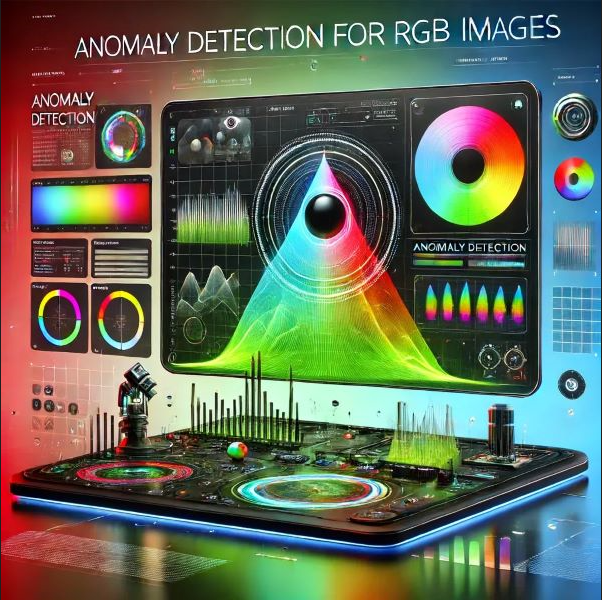

Detekcja anomalii jest zagadnieniem, które często jest realizowane w zastosowaniach biznesowych. Jednym z takich przykładów jest analiza jakości wytwarzanych produktów na linii produkcyjnej, gdzie większość produktów jest wytworzona prawidłowo (spełnia normy), a pewna niewielka liczba próbek jest wadliwa. Innym przykładem zagadnienia detekcji anomalii są systemy analizujące ruch sieciowy, a celem jest wykrycie zdarzeń odstających, np. w postaci ataków DDoS.

Zagadnienie detekcji anomalii można więc sformalizować jako znalezienie próbek/zdarzeń odstających (ang. *outliers*), które zazwyczaj pojawiają się rzadko w zbiorze. Można powiedzieć, że w zbiorze jest wiele ,,typowych" próbek, pochodzących z pewnego rozkładu danych, a celem jest znalezienie nielicznych próbek pochodzących spoza tego rozkładu.


## Zadanie
Na podstawie dostarczonego zbioru danych, zaproponuj algorytm typu *self-supervised* (częściowo nadzorowany) lub *unsupervised* (nienadzorowany) do detekcji anomalii. Są one oznaczone etykietą `1`. Próbki zawierające normalne obserwacje są oznaczone etykietą `0`. **W swoim rozwiązaniu wykorzystaj sieć neuronową**. Finalnie Twoje rozwiązanie powinno przypisać wartość dwóch zmiennych globalnych:
- `BATCH_SIZE` - rozmiaru serii danych na jakich operowały będą dataloader'y. Podczas sprawdzania wczytamy tę wartość i użyjemy do dataloder'u z danymi testowymi.
- `model` - przygotowany model, który będzie składał się z funkcji `forward()` tradycyjnie wykorzystywanej do propagacji danych przez sieć, a także z funkcji `predict()`, która ma dokonywać ostatecznego przyporządkowania danej próbki do jednej z klas: `0` lub `1`. Zmienna `model` musi być wytrenowaną instancją klasy `Model`. `model` zostanie użyty do ewaluacji rozwiązania na zbiorze testowym.

**UWAGA: Model można trenować tylko na zbiorze treningowym, który zawiera jedynie normalne obserwacje.**

**UWAGA: Nazwy zmiennych oraz sygnatura funkcji** `predict` **musi zostać niezmieniona - możesz użyć sprawdzaczki w celu weryfikacji tych wymagań.**

## Ocenianie
Po wytrenowaniu przygotowanego przez Ciebie modelu, do oceny rozwiązania wywoływana będzie metoda `predict()`. Ma ona zawierać mechanizm przyporządkowania otrzymanej na wejściu próbki danych na podstawie wyjścia modelu i potencjalnych dodatkowych, przygotowanych przez Ciebie kryteriów oceny predykcji modelu.
Jakość zaproponowanego rozwiązania będzie wyznaczona poprzez wyliczenie dokładnosci klasyfikacji (ang. *accuracy*) na zbiorze testowym, który dostępny jest dla organizatorów. Zbiór testowy jest **zbalansowany**, a obrazki w nim cechują się takimi samymi charakterystykami, jak te dostarczone uczestnikom.

Model osiągający dokładność klasyfikacji poniżej 60% otrzyma 0 punktów, powyżej 90% 1 punkt a wartości pośrednie będą liniowo skalowane w tym zakresie. Finalny wynik uczestnika będzie oceniany na podstawie wzoru poniżej:
$$
score = min(max(accuracy - 0.6, 0.0), 0.3) / 0.3
$$

gdzie $\mathrm{accuracy} \in [0, 1]$ jest dokładnością klasyfikacji na zbiorze testowym.

## Pliki zgłoszeniowe
1. Tylko ten notebook

## Ograniczenia
- Ewaluacja twojego rozwiązania (wraz z treningiem sieci neuronowej, flaga `FINAL_EVALUATION_MODE` ustawiona na `True`) na 10 000 przykładach testowych powinna trwać nie dłużej niż 15 minut na Google Colab **z** GPU.

## Ewaluacja
Pamiętaj, że podczas sprawdzania flaga `FINAL_EVALUATION_MODE` zostanie ustawiona na `True`.

Za to zadanie możesz zdobyć pomiędzy 0 i 1 punktów. Liczba punktów, które zdobędziesz będzie równa wartości `score`, wyliczonej na zbiorze testowym.

# Kod startowy

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################

FINAL_EVALUATION_MODE = False
# W czasie sprawdzania Twojego rozwiązania, zmienimy tę wartość na True
# Wartość tej flagi M U S I zostać ustawiona na False w rozwiązaniu, które nam nadeślesz!

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################

import random
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

In [ ]:
if not FINAL_EVALUATION_MODE:
    ! gdown https://drive.google.com/uc?id=1QoTW4eZctWvzmjrNrwmai9zhL8RWnhBU
    # ! gdown https://drive.google.com/uc?id=1bD38bZf8pcUyinuvYDXO56RPlXUluzxn
    # ! gdown https://drive.google.com/uc?id=108d2ERztZzq5_ZXyizxeWDOCctG5xhIy

    ! unzip anomaly.zip
    ! unzip train.zip
    ! unzip valid.zip

## Ładowanie danych

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################

TRAIN_DIR: Path = Path("./train")
VALID_DIR: Path = Path("./valid")

TRAIN_CSV: Path = Path("./train.csv")
VALID_CSV: Path = Path("./valid.csv")

In [ ]:
# Ustaw swój batch size -- będziemy wymagać obecności tej zmiennej podczas sprawdzania i użyjemy jej podczas testów
BATCH_SIZE: int = 32

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################

class ImageDataset(Dataset):
    def __init__(self, dir: Path, csv: Path):
        self.dir: Path = dir
        self.csv = pd.read_csv(csv)

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx) -> tuple[torch.Tensor, int]:
        if torch.is_tensor(idx):
            idx = idx.tolist()
        path, label = self.csv.iloc[idx]
        img = plt.imread(self.dir / path)

        to_tensor = transforms.ToTensor()
        return to_tensor(img), label


def train_dataloader() -> DataLoader:
    """Stwórz Dataloader z danymi treningowymi."""
    return DataLoader(ImageDataset(TRAIN_DIR, TRAIN_CSV), batch_size=BATCH_SIZE, shuffle=True)


def valid_dataloader() -> DataLoader:
    """Stwórz Dataloader z danymi walidacyjnymi."""
    return DataLoader(ImageDataset(VALID_DIR, VALID_CSV), batch_size=BATCH_SIZE, shuffle=False)

# Przykładowy szkielet rozwiązania + naiwne rozwiązanie

Poniżej prezentujemy proste rozwiązanie, które w oczywisty sposób nie jest optymalne. Służy temu, aby było wiadomo w jaki sposób ma działać cały notatnik.

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.rand(x.shape[0])

    def predict(self, batch: torch.Tensor) -> torch.Tensor:
        """
        Przypisz każdemu zdjęciu z batcha 0 lub 1.
        Nie zmieniaj ani nie dodawaj argumentów w tej metodzie!
        """
        predictions = torch.ones(batch.shape[0])
        return predictions


def train_model() -> Model:
    """Stwórz i wytrenuj model"""
    return Model()

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################

model = train_model()

# Kod z kryterium oceniającym

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################

def grade_solution(model):
    dataloader = valid_dataloader() # Podczas sprawdzania podmienimy to na test_dataloader

    predictions = np.concatenate([
        model.predict(images).cpu().to(dtype=torch.int32).numpy() for images, _ in dataloader
    ], axis=0)

    labels = np.concatenate([label for _, label in dataloader], axis=0, dtype=np.int32)

    accuracy = sum(labels == predictions) / len(labels)
    
    score = min(max(accuracy - 0.6, 0.0), 0.3) / 0.3

    print(f"Accuracy: {accuracy}")
    print(f'Twój wynik to {score} pkt')
    return score

## Ewaluacja wywołana na dostarczonym zbiorze
(docelowo będzie uruchomiona na zbiorze testowym)

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################

if not FINAL_EVALUATION_MODE:
    grade_solution(model)